In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-reddit/ml_reddit.txt
/kaggle/input/wikipedia-data/wikipedia.txt
/kaggle/input/ml-wikipedia/ml_wikipedia.txt


In [3]:
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RNN, SimpleRNNCell,Bidirectional, MultiHeadAttention, Input, GlobalAveragePooling1D, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
import random
from tensorflow.keras.utils import to_categorical
from collections import defaultdict
from tensorflow.keras.models import Model
from keras.layers import LeakyReLU
from tensorflow.keras import layers, models, optimizers, activations
from node2vec import Node2Vec
from collections import defaultdict
from keras.optimizers import AdamW
from tensorflow.keras.models import Model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
import json
from sklearn.model_selection import StratifiedShuffleSplit

2024-11-22 15:39:49.165620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 15:39:49.165798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 15:39:49.394631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install node2vec

In [4]:
class TemporalRandomWalkSampler:
    def __init__(self, filename=None, num_walks=3, alpha=0.5):
        self.num_walks = num_walks
        self.alpha = alpha
        if filename:
            self.temporal_network = self.load_temporal_network(filename)
        else:
            self.temporal_network = nx.Graph()

    def load_temporal_network(self, filename):
        temporal_network = nx.Graph()
        with open(filename, 'r') as file:
            next(file)  # Skip header if there is one
            for line in file:
                parts = line.strip().split(' ')
                if len(parts) == 3:
                    source, target, timestamp = parts
                    temporal_network.add_edge(source, target, time=int(timestamp))
                else:
                    print(f"Skipping invalid line: {line.strip()}")
        return temporal_network

    def sample_temporal_random_walks(self):
        node_sets = {}
        for node in self.temporal_network.nodes():
            walks = self._sample_trws(node)
            node_sets[node] = walks
        return node_sets

    def _sample_trws(self, start_node):
        walks = []
        for _ in range(self.num_walks):
            walk = self.temporal_walk(self.temporal_network, start_node)
            walks.append(walk)
        return walks

    def temporal_walk(self, G, start_node, L=7):
        current_node = start_node
        walk = [current_node]
        current_time = 0

        for _ in range(1, L + 1):
            neighbors = [(neighbor, G.edges[current_node, neighbor]['time']) for neighbor in G.neighbors(current_node)]
            valid_edges = [(neighbor, time) for neighbor, time in neighbors if time > current_time]

            if valid_edges:
                next_node, interaction_time = self.biased_edge_selection(valid_edges, current_time)
                walk.append(interaction_time)
                walk.append(next_node)
                current_node = next_node
                current_time = interaction_time
            else:
                break

        return walk

    def biased_edge_selection(self, valid_edges, current_time):
        weights = [np.exp(-self.alpha * (edge[1] - current_time)) for edge in valid_edges]
        sum_weights = np.sum(weights)

        if sum_weights == 0 or np.isnan(sum_weights):
            # Handle the case when all weights are zero or NaN
            return random.choice(valid_edges)
        else:
            normalized_weights = weights / sum_weights
            selected_index = np.random.choice(len(valid_edges), p=normalized_weights)
            return valid_edges[selected_index]

In [5]:
def extract_temporal_motifs(walks, motif_sizes):
    motifs = {}
    for size in motif_sizes:
        size_motifs = set()
        for walk in walks:
            for i in range(0, len(walk) - size * 2 + 1, 2):
                motif = tuple(walk[i:i + size * 2:2])
                size_motifs.add(motif)
        motifs[size] = size_motifs
    return motifs

def anonymize_motifs(motifs):
    node_encoder = OneHotEncoder()
    flattened_motifs = [str(node) for size in motifs for motif in motifs[size] for node in motif]
    node_encoder.fit(np.array(flattened_motifs).reshape(-1, 1))

    anonymized_motifs = {}
    for size, size_motifs in motifs.items():
        anonymized_size_motifs = set()
        for motif in size_motifs:
            encoded_motif = tuple(tuple(node_encoder.transform(np.array([[str(node)]]).reshape(-1, 1)).toarray().flatten()) for node in motif)
            anonymized_size_motifs.add(encoded_motif)
        anonymized_motifs[size] = anonymized_size_motifs

    return anonymized_motifs

def create_incidence_matrices(motifs):
    incidence_matrices = {}

    for size, size_motifs in motifs.items():
        vertices = set()
        hyperedges = []

        for motif in size_motifs:
            vertices.update(motif)
            hyperedges.append(motif)

        vertices = sorted(vertices)
        num_vertices = len(vertices)
        num_hyperedges = len(hyperedges)

        incidence_matrix = np.zeros((num_vertices, num_hyperedges))

        for j, hyperedge in enumerate(hyperedges):
            for vertex in hyperedge:
                i = vertices.index(vertex)
                incidence_matrix[i, j] = 1

        incidence_matrices[size] = (incidence_matrix, vertices, hyperedges)

    return incidence_matrices

def extract_node_features(temporal_network, incidence_matrices):
    node_features = defaultdict(list)

    for size, (incidence_matrix, vertices, hyperedges) in incidence_matrices.items():
        # Extract features from the incidence matrix for each node
        node_degree = incidence_matrix.sum(axis=1)  # Degree centrality
        node_closeness = np.reciprocal(incidence_matrix.sum(axis=1), where=(incidence_matrix.sum(axis=1) != 0))  # Closeness centrality
        node_betweenness = np.sum(incidence_matrix, axis=1)  # Betweenness centrality

        # Combine the features into a feature matrix
        features = np.column_stack((node_degree, node_closeness, node_betweenness))

        # Store the features in a dictionary with node labels as keys
        for node, feature in zip(vertices, features):
            node_features[node].append(feature)

    # Extract Node2Vec embeddings
    node2vec = Node2Vec(temporal_network, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    node2vec_features = {str(node): model.wv[str(node)] for node in temporal_network.nodes()}

    # Merge all features
    merged_features = {}
    max_motif_features_length = max(len(features) for features in node_features.values())

    for node in temporal_network.nodes():
        embedding_features = node2vec_features[str(node)]
        if node in node_features:
            basic_features = np.concatenate(node_features[node], axis=0)
            # Ensure uniform length by padding/trimming
            basic_features = pad_or_trim(basic_features, max_motif_features_length * 3)
            merged_features[node] = np.concatenate((basic_features, embedding_features))
        else:
            merged_features[node] = embedding_features

    return merged_features

In [6]:
# Merge features from all motif sizes and ensure uniform length by padding/trimming
def pad_or_trim(array, length):
    if len(array) < length:
        return np.pad(array, (0, length - len(array)), 'constant')
    else:
        return array[:length]

In [7]:
# Example usage (same as provided above)
filename = '/kaggle/input/wikipedia-data/wikipedia.txt'  # Replace with your actual file path
temporal_rw_sampler = TemporalRandomWalkSampler(filename, num_walks=30, alpha=0.5)

In [8]:
node_sets = temporal_rw_sampler.sample_temporal_random_walks()
all_walks = [walk for walks in node_sets.values() for walk in walks]
motif_sizes = [3, 4, 5, 6]
extracted_motifs = extract_temporal_motifs(all_walks, motif_sizes)

incidence_matrices = create_incidence_matrices(extracted_motifs)
# Extract node features from the incidence matrices
node_features_dict = extract_node_features(temporal_rw_sampler.temporal_network, incidence_matrices)

Computing transition probabilities:   0%|          | 0/8227 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [03:51<00:00,  4.62s/it]


In [9]:
node_features_dict

{'1': array([ 2.00000000e+00,  5.00000000e-01,  2.00000000e+00,  9.00000000e+00,
         1.11111111e-01,  9.00000000e+00,  9.00000000e+00,  1.11111111e-01,
         9.00000000e+00,  2.00000000e+00,  5.00000000e-01,  2.00000000e+00,
         4.06162471e-01, -5.01735210e-01,  2.97820717e-01,  7.15614855e-02,
         1.14549533e-01, -3.70349526e-01,  2.06535324e-01,  2.97815442e-01,
         1.20119423e-01,  1.44421861e-01, -1.44026384e-01,  1.61816195e-01,
        -2.76024669e-01, -1.97994024e-01, -2.98763305e-01, -2.54133731e-01,
        -6.16707742e-01, -7.93621421e-01, -1.17056221e-02,  1.60571650e-01,
         2.95799859e-02,  7.06944196e-03, -4.23812121e-01, -6.80369020e-01,
        -2.58548465e-02,  1.31666392e-01, -2.09797472e-01,  3.66179831e-02,
        -7.89142251e-02, -3.49876493e-01,  9.88339111e-02, -2.35880747e-01,
        -2.43902400e-01, -1.18667267e-01, -1.69085681e-01,  5.82465343e-02,
         2.09803864e-01, -6.43594610e-03,  2.07073763e-01,  1.85258552e-01,
       

In [60]:
# Convert node features dictionary to a format suitable for clustering
nodes = list(node_features_dict.keys())
max_feature_length = max(len(features) for features in node_features_dict.values())
features = np.array([pad_or_trim(features, max_feature_length) for features in node_features_dict.values()])

In [61]:
features

array([[ 2.00000000e+00,  5.00000000e-01,  2.00000000e+00, ...,
         1.53563768e-01,  6.15951717e-02, -4.39945489e-01],
       [ 1.90000000e+01,  5.26315789e-02,  1.90000000e+01, ...,
         5.47886908e-01, -2.86260736e-03, -2.64505088e-01],
       [ 1.90000000e+01,  5.26315789e-02,  1.90000000e+01, ...,
        -1.68652222e-01, -3.33558023e-01, -8.72114182e-01],
       ...,
       [ 4.87062186e-01, -5.96166030e-02,  1.10521209e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.18120292e-01, -2.48328358e-01,  7.75502026e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.70355481e-01, -8.77599791e-02,  5.17477393e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [62]:
# Use K-Means to create labels from the node features
n_clusters = 4  # Set the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
# Print clustering results
for node, label in zip(nodes, labels):
    print(f"Node ID: {node}, Cluster: {label}")

Node ID: 1, Cluster: 0
Node ID: 2, Cluster: 0
Node ID: 3, Cluster: 0
Node ID: 4, Cluster: 0
Node ID: 5, Cluster: 0
Node ID: 6, Cluster: 0
Node ID: 7, Cluster: 0
Node ID: 0, Cluster: 0
Node ID: 8, Cluster: 1
Node ID: 9, Cluster: 0
Node ID: 10, Cluster: 0
Node ID: 11, Cluster: 0
Node ID: 12, Cluster: 0
Node ID: 13, Cluster: 0
Node ID: 14, Cluster: 1
Node ID: 15, Cluster: 0
Node ID: 16, Cluster: 1
Node ID: 17, Cluster: 1
Node ID: 18, Cluster: 0
Node ID: 19, Cluster: 1
Node ID: 20, Cluster: 0
Node ID: 21, Cluster: 0
Node ID: 22, Cluster: 1
Node ID: 23, Cluster: 1
Node ID: 24, Cluster: 0
Node ID: 25, Cluster: 0
Node ID: 26, Cluster: 0
Node ID: 27, Cluster: 0
Node ID: 28, Cluster: 0
Node ID: 29, Cluster: 0
Node ID: 30, Cluster: 1
Node ID: 31, Cluster: 0
Node ID: 32, Cluster: 0
Node ID: 33, Cluster: 1
Node ID: 34, Cluster: 1
Node ID: 35, Cluster: 0
Node ID: 36, Cluster: 1
Node ID: 37, Cluster: 0
Node ID: 38, Cluster: 0
Node ID: 39, Cluster: 1
Node ID: 40, Cluster: 1
Node ID: 41, Cluster: 1
No

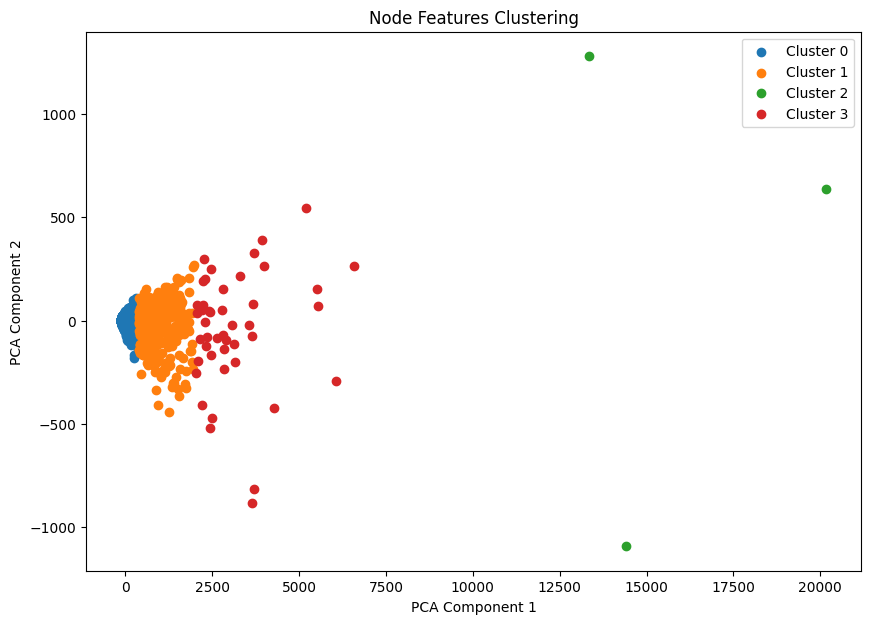

In [63]:
# Optionally, reduce dimensions for visualization using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Plot the clusters
plt.figure(figsize=(10, 7))
for i in range(n_clusters):
    cluster_points = reduced_features[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.title('Node Features Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [64]:
from imblearn.over_sampling import SMOTE

# Oversample small clusters
smote = SMOTE(random_state=42)
features_balanced, labels_balanced = smote.fit_resample(features, labels)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 6

In [49]:
from collections import Counter

print("Updated cluster distribution:", Counter(labels))

Updated cluster distribution: Counter({0: 7755, 1: 427, 3: 45})


In [50]:
# Stratified splitting to ensure all classes are represented in each split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in stratified_split.split(features, labels):
    X_train, X_rem = features[train_index], features[test_index]
    y_train, y_rem = labels[train_index], labels[test_index]
    train_node_ids, rem_node_ids = np.array(nodes)[train_index], np.array(nodes)[test_index]

# Split the remaining data into 50% validation and 50% test (which is 15% each of the total data)
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_index, test_index in stratified_split.split(X_rem, y_rem):
    X_val, X_test = X_rem[val_index], X_rem[test_index]
    y_val, y_test = y_rem[val_index], y_rem[test_index]
    val_node_ids, test_node_ids = rem_node_ids[val_index], rem_node_ids[test_index]

In [65]:
from sklearn.model_selection import train_test_split

# Perform a simple train-test split
X_train, X_rem, y_train, y_rem = train_test_split(features, labels, test_size=0.3, random_state=42)

# Further split into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [66]:
# Reshape the data to match the input shape expected by the models
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [67]:
# Check the classes in each set
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_val:", np.unique(y_val))
print("Unique classes in y_test:", np.unique(y_test))

Unique classes in y_train: [0 1 2 3]
Unique classes in y_val: [0 1 2 3]
Unique classes in y_test: [0 1 2 3]


In [68]:
def create_lstm_model(input_shape, activation_function, optimizer, n_clusters):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, activation=activation_function, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.5),  # Adding dropout to prevent overfitting
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dense(n_clusters, activation='softmax')  # Adjust for multi-class classification
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [69]:
# Define input shape (1, max_feature_length) since we've reshaped the data to have this shape
input_shape = (1, X_train.shape[2])

# Create the LSTM model
activation_function = 'tanh'
optimizer = SGD(learning_rate=0.01)
n_clusters = 4  # This should match the number of clusters used in KMeans

model = create_lstm_model(input_shape, activation_function, optimizer, n_clusters)

# Print model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 128)            │       104,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,476 (443.27 KB)

 Trainable params: 113,476 (443.27 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

# Predicting on the test set
y_pred_prob = model.predict(X_test)  # Probabilities for each class
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Predicted classes

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# For multiclass classification, AUC is calculated using the one-vs-rest approach
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # Binarize the output
auc = roc_auc_score(y_test_bin, y_pred_prob, average='weighted', multi_class='ovr')

average_precision = average_precision_score(y_test_bin, y_pred_prob, average='weighted')

# Create a DataFrame to display the results
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Average Precision'],
    'Score': [accuracy, precision, recall, f1, auc, average_precision]
})

# Display the table
print(metrics_table)


Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8315 - loss: 0.9080 - val_accuracy: 0.9449 - val_loss: 0.5228
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9436 - loss: 0.5019 - val_accuracy: 0.9449 - val_loss: 0.4502
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9501 - loss: 0.4270 - val_accuracy: 0.9449 - val_loss: 0.4167
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9438 - loss: 0.4154 - val_accuracy: 0.9449 - val_loss: 0.3935
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9437 - loss: 0.3977 - val_accuracy: 0.9449 - val_loss: 0.3928
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9456 - loss: 0.3908 - val_accuracy: 0.9449 - val_loss: 0.4009
Epoch 7/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9435 - loss: 0.4051 - val_accuracy: 0.9449 - val_loss: 0.3887
Epoch 8/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9409 - loss: 0.3987 - val_accu

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


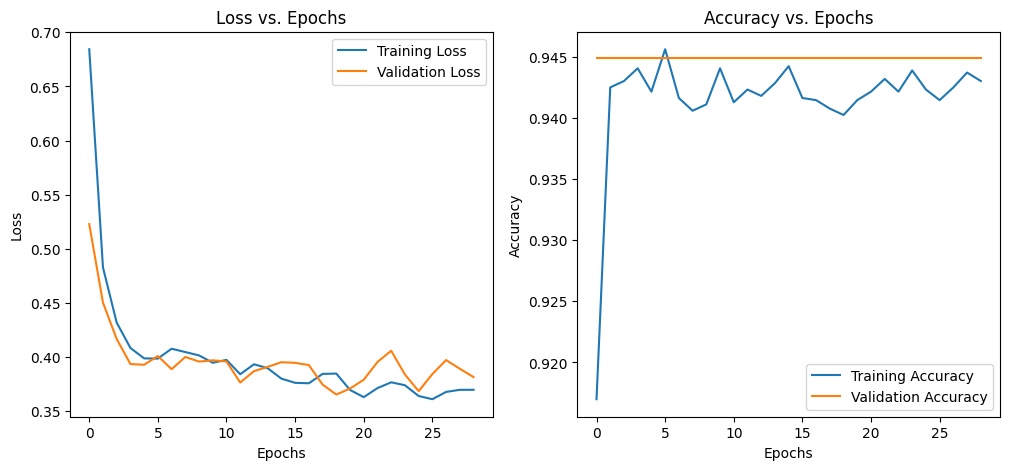

In [71]:
# Plot loss vs epochs
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

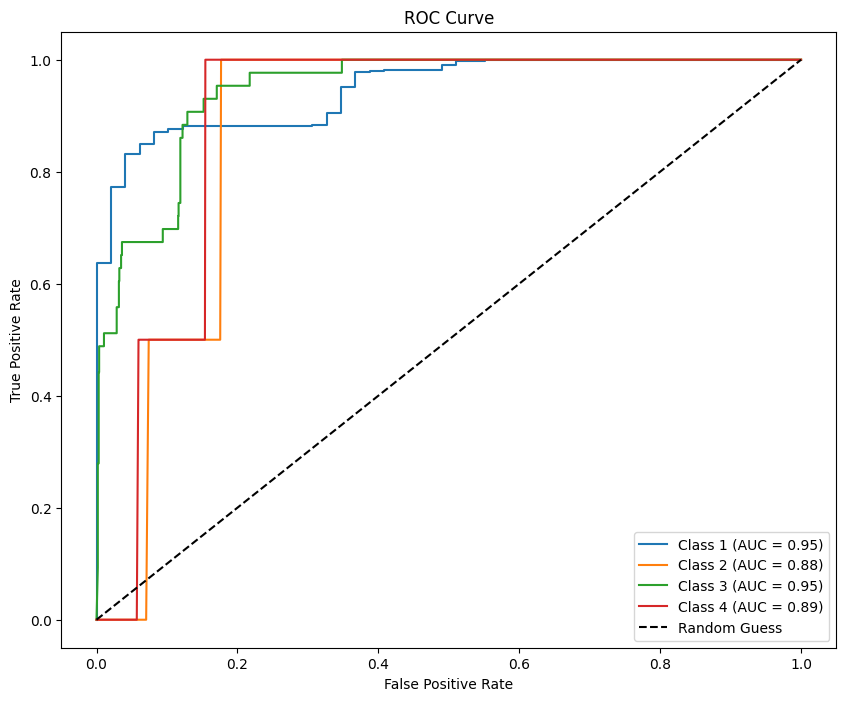

In [40]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for the ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Initialize the plot
plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random guess)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

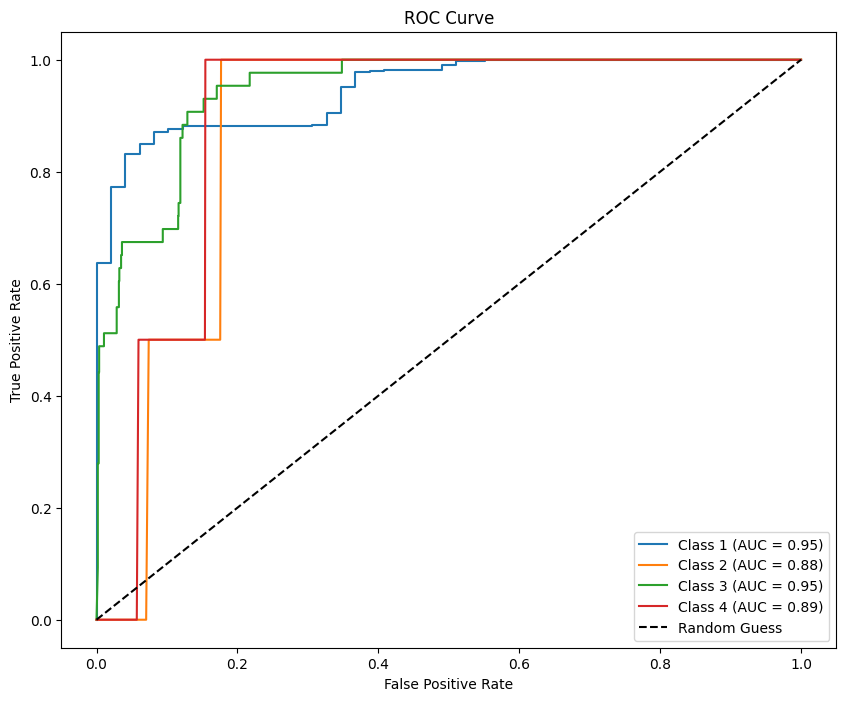

In [41]:
# ROC Curve plotting
plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random guess)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()